# Predicting the popularity of tweets

In [102]:
# Import all libraries needed through the whole notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder

RANDOM_SEED = 2055
TEST_SIZE = 0.2

# Exploratory data analysis

During the exploratory data analysis, we will look at the data to understand its structure and the relationships between the variables. We have two main goals during this phase:
1. Choose which variable will be our target variable
2. Identify the most important variables that will help us predict the target variable

## Load the data

The first step is to load the data and check the information about the columns and the data types are correct. One special thing to consider the data is that we have two datasets: one with the tweets and another with the users. We will need to join these datasets to have all the information in one place.

In [103]:
# Load both datasets
tweets = pd.read_csv('./data/tweets.csv', low_memory=False)
users = pd.read_csv('./data/users.csv')

In [104]:
# Join the datasets
users.set_index('id', inplace=True)
tweets_users = tweets.join(users, on='user_id', lsuffix='_tweet', rsuffix='_user', how='left')

### Check data has been loaded correctly

In [105]:
tweets_users

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1425590913959612419,1425590913959612419,1.628722e+12,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],...,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,1427736867739299841,1427736867739299841,1.629234e+12,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
2,1427667300488937476,1427667300488937476,1.629217e+12,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
3,1427667012105371652,1427667012105371652,1.629217e+12,2021-08-17 18:21:55,200,NaN,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
4,1427497703596990467,1427497703596990467,1.629177e+12,2021-08-17 07:09:08,200,NaN,The tech giants that refuse to massively addre...,en,[],[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40576,1427593440469061634,1427593440469061634,1.629200e+12,2021-08-17 13:29:34,200,NaN,Commencement of works. #Agenda111 https://t.c...,en,['agenda111'],[],...,7744,Ghana,352,2003463,338,1499,False,True,https://pbs.twimg.com/profile_images/817691975...,https://pbs.twimg.com/profile_banners/24721710...
40577,1427592955272089642,1427592930722820096,1.629200e+12,2021-08-17 13:27:38,200,NaN,Commencement of works. #Agenda111 https://t.c...,en,['agenda111'],[],...,7744,Ghana,352,2003463,338,1499,False,True,https://pbs.twimg.com/profile_images/817691975...,https://pbs.twimg.com/profile_banners/24721710...
40578,1427592942441598980,1427592930722820096,1.629200e+12,2021-08-17 13:27:35,200,NaN,Commencement of works. #Agenda111 https://t.c...,en,['agenda111'],[],...,7744,Ghana,352,2003463,338,1499,False,True,https://pbs.twimg.com/profile_images/817691975...,https://pbs.twimg.com/profile_banners/24721710...
40579,1427592930722820096,1427592930722820096,1.629200e+12,2021-08-17 13:27:32,200,NaN,Commencement of works. #Agenda111 https://t.c...,en,['agenda111'],[],...,7744,Ghana,352,2003463,338,1499,False,True,https://pbs.twimg.com/profile_images/817691975...,https://pbs.twimg.com/profile_banners/24721710...


At first glance, we see that some columns do not have the expected data types. We will convert them to the correct data types before we make any analysis to make sure we don't have any problems with the data types.

In [106]:
# Convert columns to the correct data types
tweets_users['id'] = tweets_users['id'].astype('str')
tweets_users['conversation_id'] = tweets_users['conversation_id'].astype('str')
tweets_users['created_at'] = pd.to_datetime(tweets_users['created_at'], unit='ms')
tweets_users['date'] = pd.to_datetime(tweets_users['date'])
tweets_users['user_id'] = tweets_users['user_id'].astype('str')
tweets_users['user_id_str'] = tweets_users['user_id_str'].astype('str')
tweets_users['video'] = tweets_users['video'].astype('bool')
tweets_users['user_rt_id'] = tweets_users['user_rt_id'].astype('str')
tweets_users['retweet_id'] = tweets_users['retweet_id'].astype('str')
tweets_users['retweet_date'] = pd.to_datetime(tweets_users['retweet_date'].str.rstrip(' CEST'))
tweets_users['join_datetime'] = pd.to_datetime(tweets_users['join_datetime'])
tweets_users['join_date'] = pd.to_datetime(tweets_users['join_date'])
tweets_users['join_time'] = pd.to_datetime(tweets_users['join_time'], format='%H:%M:%S %Z').dt.time
tweets_users['private'] = tweets_users['private'].astype('bool')
tweets_users['verified'] = tweets_users['verified'].astype('bool')

In [107]:
tweets_users.shape

(40867, 55)

In [108]:
tweets_users.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40867 entries, 0 to 40580
Data columns (total 55 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                40867 non-null  object             
 1   conversation_id   40867 non-null  object             
 2   created_at        40867 non-null  datetime64[ns]     
 3   date              40867 non-null  datetime64[ns]     
 4   timezone          40867 non-null  int64              
 5   place             34 non-null     object             
 6   tweet             40867 non-null  object             
 7   language          40867 non-null  object             
 8   hashtags          40867 non-null  object             
 9   cashtags          40867 non-null  object             
 10  user_id           40867 non-null  object             
 11  user_id_str       40867 non-null  object             
 12  username_tweet    40867 non-null  object             
 13  name_t

In [109]:
tweets_users.describe()

,created_at,date,timezone,day,hour,nlikes,nreplies,nretweets,search,near,...,retweet_date,translate,trans_src,trans_dest,join_date,tweets,following,followers,likes,media
count,40867,40867,40867.0,40867.000000,40867.000000,4.086700e+04,40867.000000,40867.000000,0.0,0.0,...,6182,0.0,0.0,0.0,40867,40867.000000,4.086700e+04,4.086700e+04,40867.000000,40867.000000
mean,2021-08-15 13:00:53.727041280,2021-08-15 15:00:53.727041280,200.0,3.816013,12.999560,1.417170e+03,78.194118,288.468569,NaN,NaN,...,2021-08-12 23:04:28.001941248,NaN,NaN,NaN,2009-01-17 07:22:25.584456960,177398.772971,1.152955e+04,1.010760e+07,13963.126728,50492.908190
min,2021-08-11 22:00:00,2021-08-12 00:00:00,200.0,1.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,NaN,...,2015-09-01 12:10:02,NaN,NaN,NaN,2006-03-21 00:00:00,5.000000,0.000000e+00,1.070000e+02,0.000000,5.000000
25%,2021-08-13 14:56:50,2021-08-13 16:56:50,200.0,2.000000,6.000000,6.000000e+00,0.000000,4.000000,NaN,NaN,...,2021-08-13 05:30:01.249999872,NaN,NaN,NaN,2007-05-12 00:00:00,40113.000000,4.180000e+02,3.039465e+06,353.000000,3402.000000
50%,2021-08-15 15:30:01,2021-08-15 17:30:01,200.0,4.000000,15.000000,3.900000e+01,3.000000,16.000000,NaN,NaN,...,2021-08-15 00:38:46,NaN,NaN,NaN,2008-10-09 00:00:00,132248.000000,8.620000e+02,4.878881e+06,2600.000000,22586.000000
75%,2021-08-17 13:45:32,2021-08-17 15:45:32,200.0,5.000000,19.000000,2.060000e+02,24.000000,74.000000,NaN,NaN,...,2021-08-16 23:37:16,NaN,NaN,NaN,2009-10-22 00:00:00,306127.000000,2.265000e+03,1.025547e+07,8759.000000,75519.000000
max,2021-08-18 22:00:00,2021-08-19 00:00:00,200.0,7.000000,23.000000,1.920242e+06,88035.000000,541964.000000,NaN,NaN,...,2021-08-18 23:51:40,NaN,NaN,NaN,2021-06-21 00:00:00,508811.000000,4.200793e+06,1.299093e+08,492144.000000,236024.000000
std,NaN,NaN,0.0,1.887138,7.328175,1.824648e+04,983.854499,4644.698916,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,148999.823601,1.628862e+05,1.322146e+07,51451.295821,62376.057012


In [110]:
tweets_users.nunique()

id                  40581
conversation_id     37273
created_at          36756
date                36756
timezone                1
place                  22
tweet               40026
language               40
hashtags             2561
cashtags                4
user_id               847
user_id_str           847
username_tweet        847
name_tweet            847
day                     7
hour                   24
link                40581
urls                19576
photos               5344
video                   2
thumbnail            8661
retweet                 2
nlikes               4573
nreplies             1258
nretweets            2281
quote_url            2446
search                  0
near                    0
geo                     0
source                  0
user_rt_id           3560
user_rt              6046
retweet_id           6048
reply_to             3576
retweet_date         5972
translate               0
trans_src               0
trans_dest              0
name_user   

In [111]:
tweets_users.isnull().sum()

id                      0
conversation_id         0
created_at              0
date                    0
timezone                0
place               40833
tweet                   0
language                0
hashtags                0
cashtags                0
user_id                 0
user_id_str             0
username_tweet          0
name_tweet              0
day                     0
hour                    0
link                    0
urls                    0
photos                  0
video                   0
thumbnail           31644
retweet                 0
nlikes                  0
nreplies                0
nretweets               0
quote_url               0
search              40867
near                40867
geo                 40867
source              40867
user_rt_id              0
user_rt             34685
retweet_id              0
reply_to                0
retweet_date        34685
translate           40867
trans_src           40867
trans_dest          40867
name_user   

The dataset has been loaded correctly, no issues were found during the process, and the data is coherent with what we could expect from each of the variables.



### Data exploration

After loading correctly the dataset and checking the data types, we will do an exploratory data analysis. This will help us understand the data and find out which is the most relevant variables for our project and how they can help us find a solution for the problem.

In [112]:
tweets_users.head(10)

,id,conversation_id,created_at,date,timezone,place,tweet,language,hashtags,cashtags,...,tweets,location,following,followers,likes,media,private,verified,avatar,background_image
0,1425590913959612419,1425590913959612419,2021-08-11 22:52:14,2021-08-12 00:52:14,200,NaN,RT @girlsalliance: We're so proud of the four ...,en,[],[],...,1770,"Washington, DC",16,20854298,184,461,False,True,https://pbs.twimg.com/profile_images/136674780...,https://pbs.twimg.com/profile_banners/40948655...
1,1427736867739299841,1427736867739299841,2021-08-17 20:59:29,2021-08-17 22:59:29,200,NaN,Some casual suggestions to 😏SLIDE😏 into when u...,en,"['shoesdaytuesday', 'afterskewlslide']",[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
2,1427667300488937476,1427667300488937476,2021-08-17 16:23:03,2021-08-17 18:23:03,200,NaN,RT @ValaAfshar: You are not your job.,en,[],[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
3,1427667012105371652,1427667012105371652,2021-08-17 16:21:55,2021-08-17 18:21:55,200,NaN,What have we become 😔😂 Toddler Cites Freedom ...,en,[],[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
4,1427497703596990467,1427497703596990467,2021-08-17 05:09:08,2021-08-17 07:09:08,200,NaN,The tech giants that refuse to massively addre...,en,[],[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
5,1426598917471305735,1426598917471305735,2021-08-14 17:37:41,2021-08-14 19:37:41,200,NaN,RT @peterdaou: An Italian town hit 124 degrees...,en,['climateemergency'],[],...,11420,NaN,235,108819032,7995,2170,False,True,https://pbs.twimg.com/profile_images/139246535...,https://pbs.twimg.com/profile_banners/21447363...
6,1425588921233133572,1425588921233133572,2021-08-11 22:44:19,2021-08-12 00:44:19,200,NaN,Thank you @MTV @vmas! ⚔️💓 https://t.co/iyo2KW...,en,[],[],...,9519,NaN,119314,83675119,2310,1795,False,True,https://pbs.twimg.com/profile_images/142258922...,https://pbs.twimg.com/profile_banners/14230524...
7,1427927723356430337,1427904450136510464,2021-08-18 09:37:53,2021-08-18 11:37:53,200,NaN,@Jefflez @LeroyAhBen Love you !!!,en,[],[],...,10252,Citizen of the World Dahhhling,188,21612341,4346,2504,False,True,https://pbs.twimg.com/profile_images/134656973...,https://pbs.twimg.com/profile_banners/19248106...
8,1427806400919580672,1427806400919580672,2021-08-18 01:35:47,2021-08-18 03:35:47,200,NaN,Why would anyone be shocked that I’m drinking ...,en,[],[],...,10252,Citizen of the World Dahhhling,188,21612341,4346,2504,False,True,https://pbs.twimg.com/profile_images/134656973...,https://pbs.twimg.com/profile_banners/19248106...
9,1427758371873202177,1427758371873202177,2021-08-17 22:24:56,2021-08-18 00:24:56,200,NaN,RT @mrtimchan: Wrote about @MariahCarey's new ...,en,[],[],...,10252,Citizen of the World Dahhhling,188,21612341,4346,2504,False,True,https://pbs.twimg.com/profile_images/134656973...,https://pbs.twimg.com/profile_banners/19248106...


**The dataset is formed by more than 40k records and 55 columns.** Each row represents a tweet and has additional information about the user who posted it. The data is collected from 2021/08/11 to 2021/08/18.

There is some data that is not relevant for our problem, **the dataset contains rows that do not represent original tweets, but retweets instead.** For this reason, we will filter out these records from the original dataset to keep only the original tweets.

In order to find out which tweets are going to be the most relevant, we will have to define a target variable that determines the popularity of a tweet. Considering we are creating content for social media, we look for users who are willing to interact and read more about the content of the tweet and, therefore, read the article we share. **For this reason, we will use the number of comments as the target variable**, as it represents the users which read the tweet and wanted to share their thoughts and discuss about it.

A tweet will be popular if it has more comments than the 90% of the dataset. This threshold is rather restrictive but leaves us with enough tweets for a journalist in the company to write an article about a topic that is comfortable for him.

40k * 0.2 = 8k popular tweets  
8k / 7 days = ~1200 tweets per day  
1200 / 24 hours = 50 tweets per hour  

50 tweets per hour is a more than reasonable amount of tweets for a company dedicated to content creation to write an article about the tweet. For now, even thought it could be a lot of tweets, we will keep this partition so the data is not too unbalanced and then we could adjusted based on the threshold if needed.

In [113]:
tweets_users['popular'] = tweets_users['nreplies'] > tweets_users['nreplies'].quantile(0.80)

The dataset contains a broad number of features, some of them are not relevant for our problem or are just redundant. After a brief analysis, we can see that the following columns are relevant for our problem and will be need to be further analyzed:
    - day: The day of the week (1 to 7) when the tweet was posted
    - hour: The hour of the day (0 to 23) when the tweet was posted
    - followers: The number of followers the user has
    - conversation_id (vs id): If conversation_id is different from id, it means the tweet is a reply to another tweet. Even thought the most straight forward approach for this variable would be to delete the rows that are replies, since they will not be the most relevant tweets. It can also be interesting to keep it, as a popular reply to a tweet could mean high engagement. 
    
To further analyze the data, we will plot some graphs to understand the distribution of the data and the relationships between the variables.

Text(0, 0.5, 'Count')

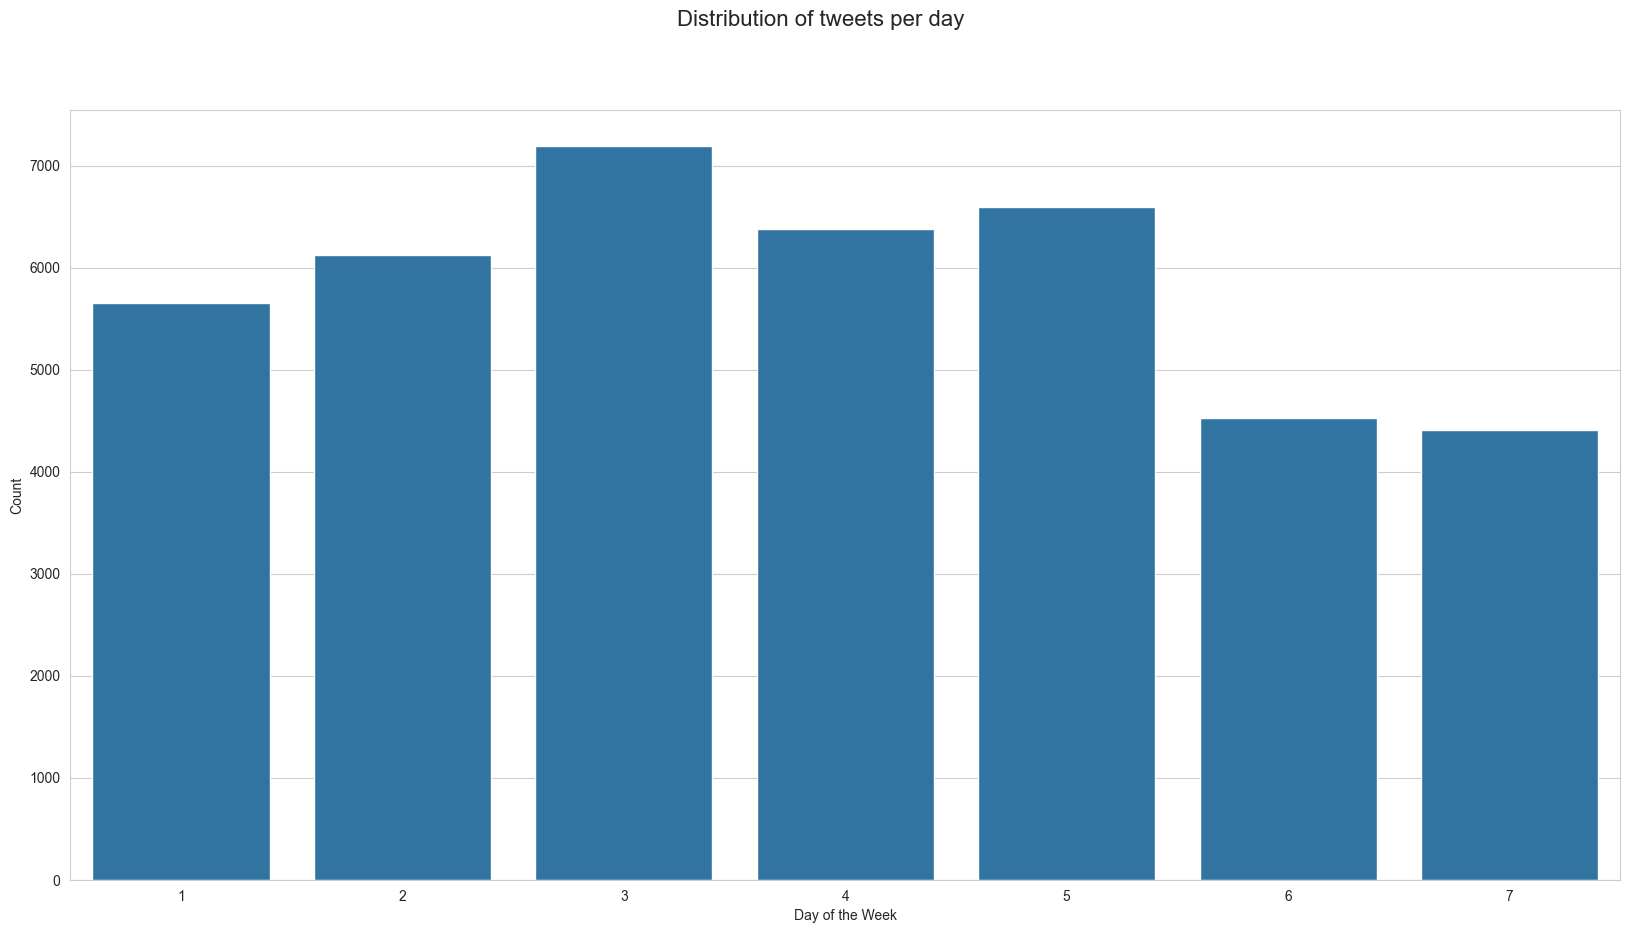

In [114]:
figure = plt.figure(figsize=(20, 10))
axe = figure.add_subplot()

figure.suptitle('Distribution of tweets per day', fontsize=16)

sns.countplot(ax=axe, x='day', data=tweets_users)
axe.set_xlabel('Day of the Week')
axe.set_ylabel('Count')

Text(0, 0.5, 'Percentage of popular tweets')

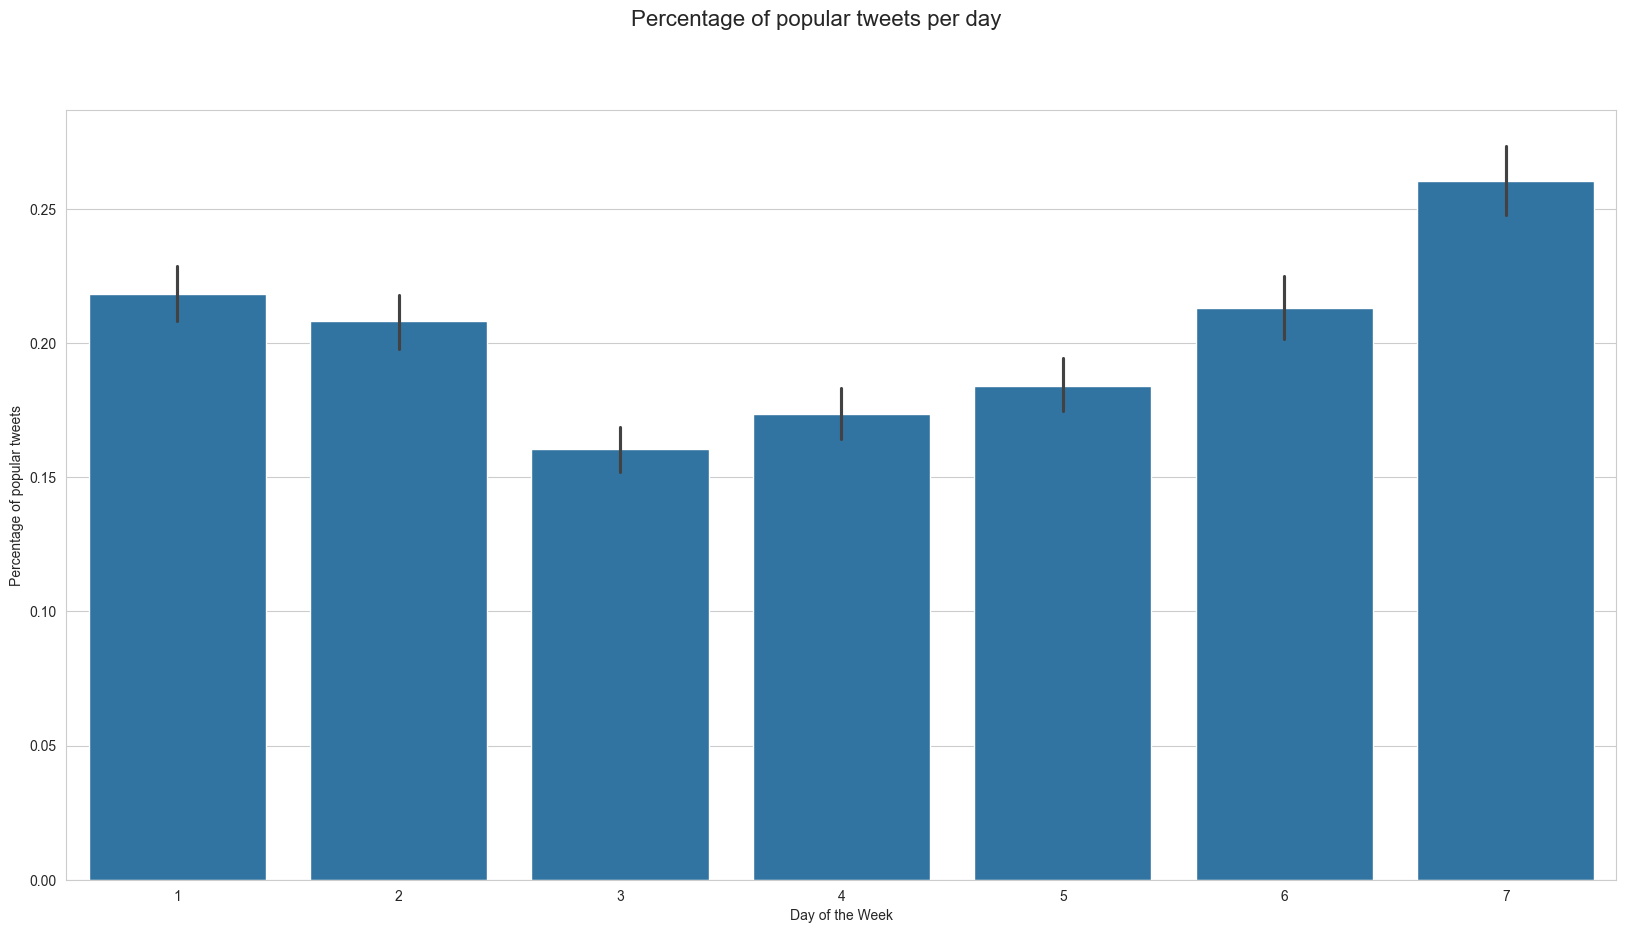

In [115]:
figure = plt.figure(figsize=(20, 10))
axe = figure.add_subplot()

figure.suptitle('Percentage of popular tweets per day', fontsize=16)

sns.barplot(ax=axe, x='day', y='popular', data=tweets_users)
axe.set_xlabel('Day of the Week')
axe.set_ylabel('Percentage of popular tweets')

As we can see on the graphs, the distribution of the tweets is pretty even during the week, with a small increase during the middle of the week and a small decrease during the weeks. However, the percentage of popular tweets is the opposite. This could be really helpful for the model

## Data cleansing and feature engineering

After defining the target variable and the most relevant features, we will clean the data to remove any irrelevant columns and rows as we have defined in the previous section.

In [116]:
# Drop tweets that are retweets
tweets_users = tweets_users[tweets_users['retweet'] == False]

The variable `followers` has a big number of outliers. Even thought the data has been extracted from popular Twitter accounts, there are still accounts that have a massive number of followers. We categorize the followers into 5 categories:
- 0 - 1.000.000 followers
- 1.000.000 - 2.500.000 followers
- 2.500.000 - 5.000.000 followers
- 5.000.000 - 10.000.000 followers
- 10.000.000+ followers

In [117]:
# Categorize the followers using .loc to avoid the SettingWithCopyWarning
tweets_users.loc[:, 'followers'] = pd.cut(tweets_users['followers'],
                                          bins=[0, 1_000_000, 2_500_000, 5_000_000, 10_000_000, float('inf')],
                                          labels=['0-1M', '1M-2.5M', '2.5M-5M', '5M-10M', '10M+'])
tweets_users['followers'].value_counts()

followers
2.5M-5M    9935
10M+       9681
5M-10M     7735
1M-2.5M    4224
0-1M       3110
Name: count, dtype: int64

For variables day and hour, we will transform them into cycler features. This helps the model realize that the hour 0 is closer to the hour 23 than to the hour 1, and the day 1 is closer to the day 7 than to the day 2.

In [118]:
tweets_users = tweets_users.copy()

# Transform day column into a cyclic feature
tweets_users['day_sin'] = tweets_users['day'].apply(lambda x: np.sin(2 * np.pi * x / 7))
tweets_users['day_cos'] = tweets_users['day'].apply(lambda x: np.cos(2 * np.pi * x / 7))

# Transform hour column into a cyclic feature
tweets_users['hour_sin'] = tweets_users['hour'].apply(lambda x: np.sin(2 * np.pi * x / 24))
tweets_users['hour_cos'] = tweets_users['hour'].apply(lambda x: np.cos(2 * np.pi * x / 24))

Before going into the training section, we will take a look at the final dataset.

In [119]:
features_chosen = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'followers', 'popular']

tweets_users = tweets_users[features_chosen]
tweets_users

,day_sin,day_cos,hour_sin,hour_cos,followers,popular
1,0.974928,-0.222521,-0.500000,8.660254e-01,10M+,True
3,0.974928,-0.222521,-1.000000,-1.836970e-16,10M+,True
4,0.974928,-0.222521,0.965926,-2.588190e-01,10M+,True
6,-0.433884,-0.900969,0.000000,1.000000e+00,10M+,True
7,0.433884,-0.900969,0.258819,-9.659258e-01,10M+,False
...,...,...,...,...,...,...
40576,0.974928,-0.222521,-0.258819,-9.659258e-01,1M-2.5M,True
40577,0.974928,-0.222521,-0.258819,-9.659258e-01,1M-2.5M,False
40578,0.974928,-0.222521,-0.258819,-9.659258e-01,1M-2.5M,False
40579,0.974928,-0.222521,-0.258819,-9.659258e-01,1M-2.5M,True


## Model training

First we will split the data into training and test.

In [120]:
# Define the features and the target variable
model_features = ['day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'followers']
model_target = 'popular'

X = tweets_users[model_features]
y = tweets_users[model_target]


In [121]:
# Convert the followers column into a numerical column with label encoding
label_encoder = LabelEncoder()
X.loc[:, 'followers'] = label_encoder.fit_transform(X['followers'])

In [129]:
# Split the data into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

We are going to choose the following 4 models to train and compare:
- Logistic Regression
- Random Forest
- Gradient Boosting
- k-Nearest Neighbors (kNN)

First, we will define some hyperparameters for each model. Then we will use GridSearchCV to find the best hyperparameters for each model.

In [130]:
logistic_regression_hyper_param_grid = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear'],
}

random_forest_hyper_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

gradient_boosting_hyper_param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

knn_hyper_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}

Initialize the models

In [131]:
logistic_regression = LogisticRegression(class_weight='balanced')
random_forest = RandomForestClassifier(class_weight='balanced')
gradient_boosting = GradientBoostingClassifier()
knn = KNeighborsClassifier()

Now we will make the GridSearchCV. This will find the best hyperparameters, making use of cross-validation.
The scoring used is recall, as explained in the previous section we want to maximize the number of popular tweets and never let a popular tweet be classified as not popular.

In [132]:
grid_search_logistic_regression = GridSearchCV(logistic_regression, logistic_regression_hyper_param_grid, cv=5,
                                               scoring='recall')
grid_search_random_forest = GridSearchCV(random_forest, random_forest_hyper_param_grid, cv=5, scoring='recall')
grid_search_gradient_boosting = GridSearchCV(gradient_boosting, gradient_boosting_hyper_param_grid, cv=5,
                                             scoring='recall')
grid_search_knn = GridSearchCV(knn, knn_hyper_param_grid, cv=5, scoring='recall')

Train the models

In [133]:
grid_search_logistic_regression.fit(X_train, y_train)
grid_search_random_forest.fit(X_train, y_train)
grid_search_gradient_boosting.fit(X_train, y_train)
grid_search_knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

We will keep the best models of each type in order to evaluate them.

In [134]:
best_logistic_regression = grid_search_logistic_regression.best_estimator_
best_random_forest = grid_search_random_forest.best_estimator_
best_gradient_boosting = grid_search_gradient_boosting.best_estimator_
best_knn = grid_search_knn.best_estimator_

## Model evaluation

In [135]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")


print("Logistic Regression:")
evaluate_model(best_logistic_regression, X_test, y_test)
print("\nRandom Forest:")
evaluate_model(best_random_forest, X_test, y_test)
print("\nGradient Boosting:")
evaluate_model(best_gradient_boosting, X_test, y_test)
print("\nk-Nearest Neighbors:")
evaluate_model(best_knn, X_test, y_test)

Logistic Regression:
Accuracy: 0.5781
Precision: 0.3136
Recall: 0.6445
F1 Score: 0.4219
ROC-AUC: 0.6009

Random Forest:
Accuracy: 0.6719
Precision: 0.3883
Recall: 0.6494
F1 Score: 0.4860
ROC-AUC: 0.6642

Gradient Boosting:
Accuracy: 0.7617
Precision: 0.5038
Recall: 0.1587
F1 Score: 0.2414
ROC-AUC: 0.5548

k-Nearest Neighbors:
Accuracy: 0.7307
Precision: 0.4064
Recall: 0.2764
F1 Score: 0.3290
ROC-AUC: 0.5748


As we can see, due to the imbalance of the dataset, the recall is very low for all models. RandomForest is the one which perform the best overall and we will choose it as the best model. As the last step, we will adjust the threshold for the popular tweets to see if we can improve the recall.

In [138]:
y_pred = best_random_forest.predict_proba(X_test)[:, 1] > 0.2
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall:.4f}")

Recall: 0.9590


## Conclusions and model usage

Predicting the popularity of a tweet is a complicated task. With the help of the model trained it is possible to filter out most of the tweets that might have a chance to be popular. Considering the threshold chosen and the amount of tweets written every hour, there will be a broad pool of tweets that one of the journalists can choose from to write an article about.

The model can be used in the following way, for example. Create a script that runs every few minutes and predicts the popularity of the tweets that have been posted since the last run. If the model detects a tweet that has a high chance of being popular, it could be posted in like internal app for the company. Then journalists can choose from these tweets to write an article about it based on their expertise (politics, sports, etc).